In [219]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [220]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        self.time_start = 0
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])/2
        self.Prec[:, 0,:,:] = 1/self.g * self.qv[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])/2
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])/2
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

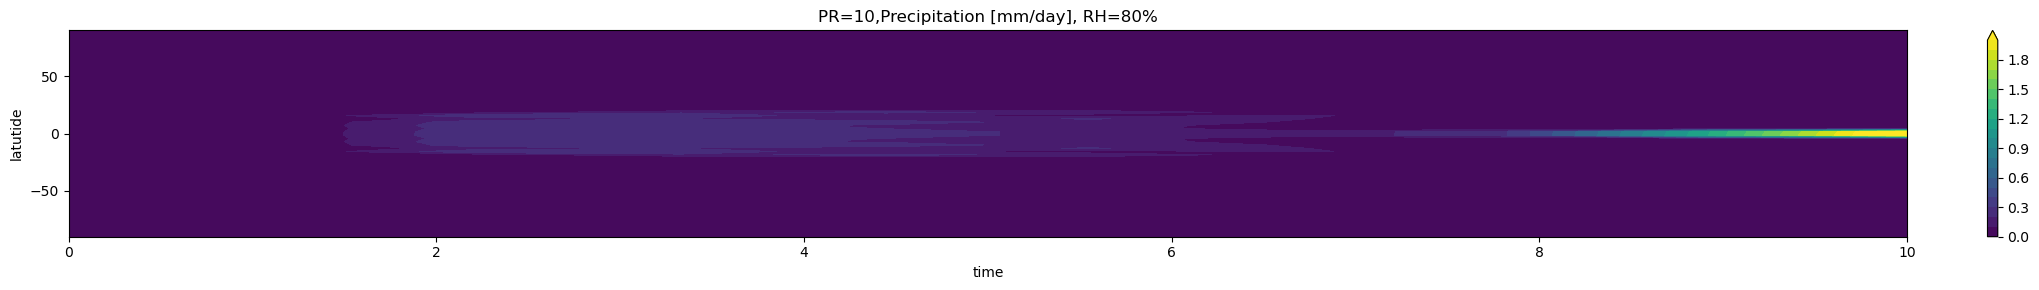

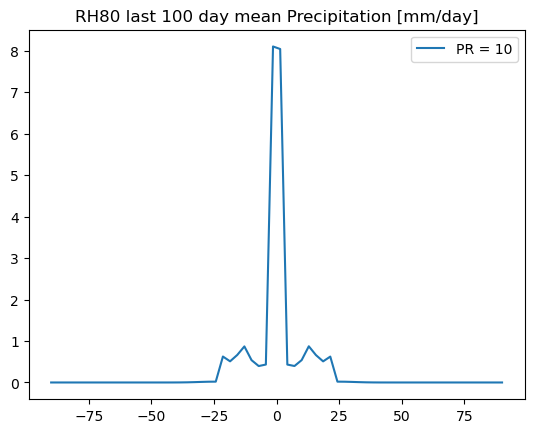

In [221]:
file = "0_10day_test_warm_start_all.dat"
# dycore = Dycore(file)
dycore = Dycore(file)
# plt.close()
time = np.linspace(0,10,10)
y    = np.linspace(-90,90,64)

yy, tt = np.meshgrid(y,time)
a      = int(0)
fig    = plt.figure(figsize=(21,3))
for pr in range(10,20,10):
    # file   = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    # file = "t_init_RH80_PR10_1600day_test_all.dat"
    # file = "test_final.dat"
    dycore = Dycore(file)
    # get_KE = dycore.cal_KE()   
    Prec   = dycore.cal_pre()

    # t_mean = dycore.cal_t()
    # t_mean2 = dycore.cal_t_last()
    
    
    # CS = plt.contourf(tt, yy, get_KE,levels=21, extend="both")
    
    CS = plt.contourf(tt, yy, Prec[:,:] * 86400,levels=np.linspace(0,2,21), extend="max")
        
    # CS = plt.contourf(tt, yy, t_mean, levels=21, extend="both")
    
    
    plt.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04)
    # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
    plt.title(f"PR={pr},Precipitation [mm/day], RH=80%")
    # ax[a].set_title(f"T [K], PR={pr}")
    
    plt.xlabel("time")
    plt.ylabel("latutide")
    a += 1
    ### test
    
plt.tight_layout()
# plt.savefig("Without LH return precipitation.png", dpi=300., bbox_inches='tight')
plt.show()
###############################################################################
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)
xx, yy = np.meshgrid(x,y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
plt.title("RH80 last 100 day mean Precipitation [mm/day]")

for pr in range(10,20,10):
    # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    dycore = Dycore(file)
    Prec   = dycore.cal_pre()
    Prec_mean  = np.nanmean(Prec[-5:,:] * 86400, axis=0)
    plt.plot(y, Prec_mean * int(pr), label=f"PR = {pr}")
plt.legend()
plt.show()


Text(0.5, 1.0, 'original file qv_diff')

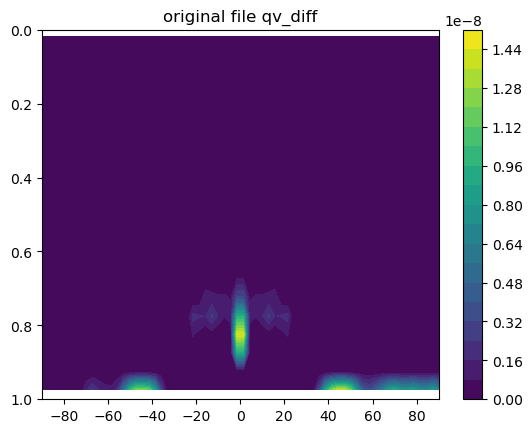

In [222]:
qv_diff = dycore.qv_diff
qv_diff_mean = np.nanmean(qv_diff[-5:,:,:,:], axis=(0,3))
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_diff_mean, levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original file qv_diff")

(20, 64)
(20, 64)


Text(0.5, 1.0, 'original file qv')

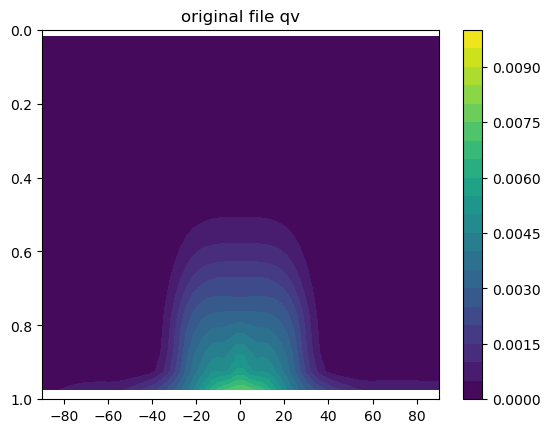

In [223]:
qv = dycore.qv
qv_mean = np.nanmean(qv[:,:,:,:], axis=(0,3))
# xx, yy = dycore.xx, dycore.yy
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
print(np.shape(yy))
print(np.shape(sigma_mean2))

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_mean, levels=np.linspace(0,0.01,21))
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original file qv")


In [224]:
plt.close()

In [225]:
# dycore = Dycore(file)
# dycore = Dycore(file)
# plt.close()

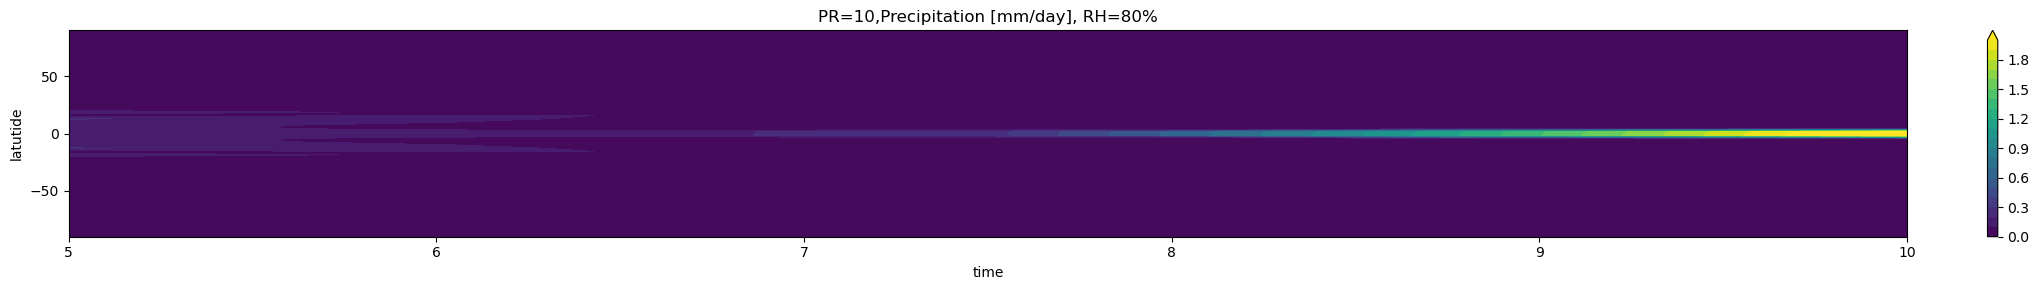

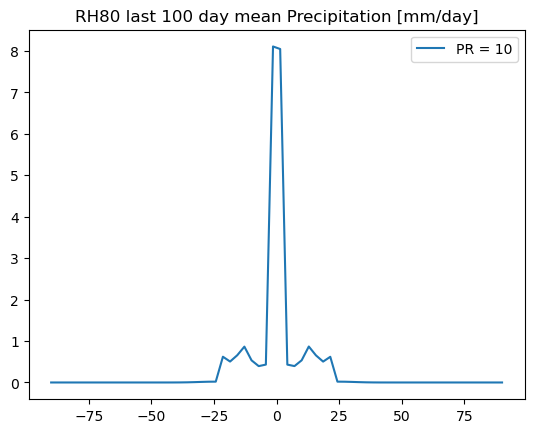

In [226]:
file = "5_10day_test_warm_start_all.dat"
time = np.linspace(5,10,5)
y    = np.linspace(-90,90,64)

yy, tt = np.meshgrid(y,time)
a      = int(0)
fig    = plt.figure(figsize=(21,3))
for pr in range(10,20,10):
    # file   = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    # file = "t_init_RH80_PR10_1600day_test_all.dat"
    # file = "test_final.dat"
    dycore = Dycore(file)
    # get_KE = dycore.cal_KE()   
    Prec   = dycore.cal_pre()

    # t_mean = dycore.cal_t()
    # t_mean2 = dycore.cal_t_last()
    
    
    # CS = plt.contourf(tt, yy, get_KE,levels=21, extend="both")
    
    CS = plt.contourf(tt, yy, Prec[:,:] * 86400,levels=np.linspace(0,2,21), extend="max")
        
    # CS = plt.contourf(tt, yy, t_mean, levels=21, extend="both")
    
    
    plt.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04)
    # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
    plt.title(f"PR={pr},Precipitation [mm/day], RH=80%")
    # ax[a].set_title(f"T [K], PR={pr}")
    
    plt.xlabel("time")
    plt.ylabel("latutide")
    a += 1
    ### test
    
plt.tight_layout()
# plt.savefig("Without LH return precipitation.png", dpi=300., bbox_inches='tight')
plt.show()
###############################################################################
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)
xx, yy = np.meshgrid(x,y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
plt.title("RH80 last 100 day mean Precipitation [mm/day]")

for pr in range(10,20,10):
    # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    dycore = Dycore(file)
    Prec   = dycore.cal_pre()
    Prec_mean  = np.nanmean(Prec[:,:] * 86400, axis=0)
    plt.plot(y, Prec_mean * int(pr), label=f"PR = {pr}")
plt.legend()
plt.show()


In [227]:
qv = dycore.qv
qv_mean = np.nanmean(qv[:,:,:,:], axis=(0,3))

(20, 64)
(20, 64)


Text(0.5, 1.0, 'test file qv')

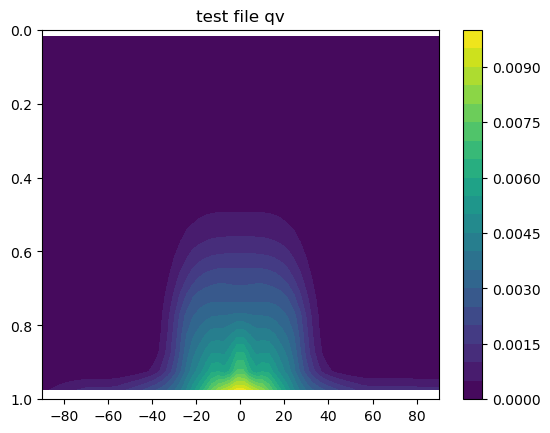

In [228]:
# xx, yy = dycore.xx, dycore.yy
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
print(np.shape(yy))
print(np.shape(sigma_mean2))

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_mean, levels=np.linspace(0,0.01,21))
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("test file qv")


Text(0.5, 1.0, 'test file qv_diff')

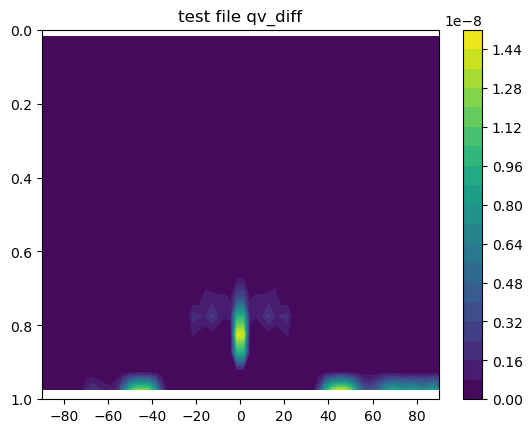

In [229]:
qv_diff = dycore.qv_diff
qv_diff_mean = np.nanmean(qv_diff[:,:,:,:], axis=(0,3))
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_diff_mean, levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("test file qv_diff")


In [230]:
plt.close()